In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import umap
from tqdm import tqdm

from utils import prepare_data


In [2]:
### 1. Prepare Data

# Import 
dna_methylation = prepare_data("DNAMethylation.csv", transpose=True, normalise=True)
rna_seq = prepare_data("RNAseq.csv", transpose=True, normalise=True)

# merge
data = pd.merge(dna_methylation, rna_seq, left_index=True, right_index=True)

In [3]:
### 2. Latent Space Encoding

# import model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = torch.load("model_v0.pth", map_location=torch.device(device))

# encode data
tensor_data = torch.tensor(data.to_numpy(), dtype=torch.float32).to(device) 
model.eval()
with torch.inference_mode():
    encoded_data = model.encode(tensor_data)

# convert to dataframe
encoded_dataframe = pd.DataFrame(encoded_data)

100%|██████████| 39/39 [00:05<00:00,  7.13it/s]


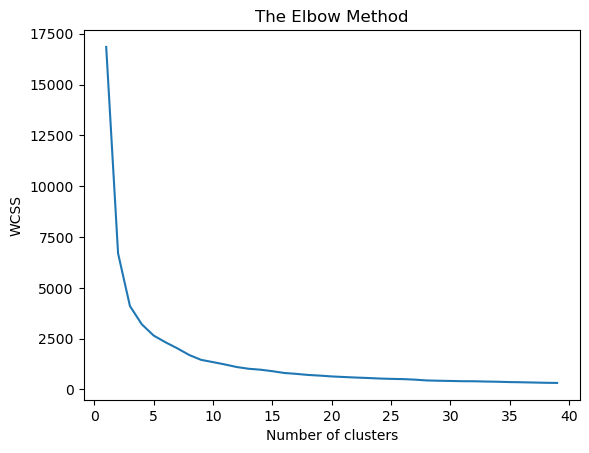

In [4]:
### 3. K-Means Clustering

# find the optimal number of clusters - elbow method
wcss = []
clusters_range = range(1, 40)

for i in tqdm(clusters_range):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', n_init='auto', random_state = 42)
    kmeans.fit(encoded_dataframe)
    wcss.append(kmeans.inertia_)
plt.plot(clusters_range, wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [5]:
from kneed import KneeLocator

knee_locator = KneeLocator(clusters_range, wcss, curve="convex", direction="decreasing")
print(f"Elbow Point: {knee_locator.elbow}")

Elbow Point: 5


In [6]:
# training
kmeans = KMeans(n_clusters = 5, init = 'k-means++', n_init='auto', random_state = 42)
y_kmeans = kmeans.fit_predict(encoded_dataframe)

/Users/frankpolak/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


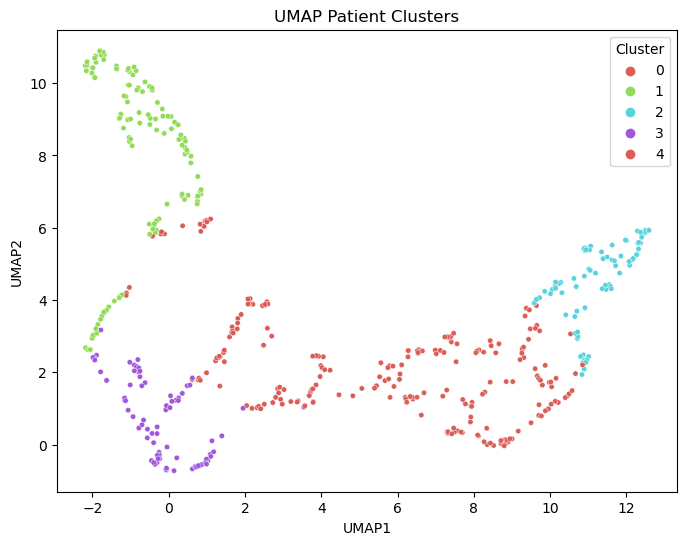

In [7]:
### UMAP - Visualisation

umap_2d = umap.UMAP(n_components=2, random_state=42)
df_2d = umap_2d.fit_transform(encoded_dataframe) 

# Convert reduced data to a new DataFrame
df_umap = pd.DataFrame(df_2d, columns=["UMAP1", "UMAP2"])
df_umap["Cluster"] = y_kmeans

# Plot UMAP with cluster colors
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_umap["UMAP1"], y=df_umap["UMAP2"], hue=df_umap["Cluster"], palette="hls", s=15)
plt.title("UMAP Patient Clusters")
plt.legend(title="Cluster")
plt.show()

In [8]:
# 3-D UMAP
umap_3d = umap.UMAP(n_components=3, random_state=42)
df_3d = umap_3d.fit_transform(encoded_dataframe)
df_umap_3d = pd.DataFrame(df_3d, columns=["UMAP1", "UMAP2", "UMAP3"])
df_umap_3d["Cluster"] = y_kmeans

fig = px.scatter_3d(x=df_umap_3d["UMAP1"], y=df_umap_3d["UMAP2"], z=df_umap_3d["UMAP3"], color=df_umap["Cluster"], )
fig.update_traces(marker=dict(size=3))
fig.show()


/Users/frankpolak/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
